Accelerating portable HPC Applications with Standard C++
===

# Lab 1: 2D Unsteady Heat Equation

In this tutorial we will learn how to do multi-dimensional iteration in C++17 and C++23 and how to integrate parallel algorithms with pre-existing MPI applications, by accelerating a 2D heat equation solver (see slides).

A working implementation is provided in [starting_point.cpp].
Please take 5 minutes to skim through it.

[starting_point.cpp]: ./starting_point.cpp

## Getting started

Let's start by compiling and running the starting point:


In [2]:
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat starting_point.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 4000

E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
E(t=0.00038147) = 0.0210538
E(t=0.000572205) = 0.0257573
Domain 1024x1024 (0.0167772 GB): 8.69287 GB/s


Note:

* MPI implementation is `OpenMPI`, the environment variable `OMPI_CXX` selects the C++ compiler to be used, e.g., `OMPI_CXX=g++` uses GCC
* Need to use the `mpicxx` compiler-wrapper to compile
* Because we are running in a container, we need to disable some MPI features with: `OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root`
* The binary invocation itself is: `./heat 1024 1024 4000`, the binary takes three arguments: NX NY NITERATIONS , that is, the number of unknowns in x and y dimensions, and the number of iterations to compute.

The binary writes a solution to an `output` file, that can be converted to a png file using the `vis` script or the following function:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#plt.style.use('dark_background') # Uncomment for dark background

def visualize(name = 'output'):
    f = open(name, 'rb')
    grid = np.fromfile(f, dtype=np.uint64, count=2, offset=0)

    nx = grid[0]
    ny = grid[1]

    times = np.fromfile(f, dtype=np.float64, count=1, offset=0)
    time = times[0]

    values = np.fromfile(f, dtype=np.float64, offset=0)
    assert len(values) == nx * ny, f'{len(values)} != {nx * ny}'
    values = values.reshape((nx, ny))

    print(f'Plotting grid {nx}x{ny}, t = {time}')

    plt.title(f'Temperature at t = {time:.3f} [s]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.pcolormesh(values, cmap=plt.cm.jet, vmin=0, vmax=values.max())
    plt.colorbar()
    plt.savefig('output.png', transparent=True, bbox_inches='tight', dpi=300)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-airqyp_l because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Plotting grid 2048x1024, t = 0.000762939453125


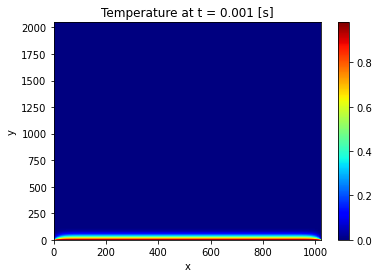

In [4]:
visualize()

## Exercise 0: parallelize with C++ parallel algorithms

The goal of this exercise is to parallelize the `stencil` and `initialize` implementations using the C++ parallel algorithms.

A template for the solution is provided in [exercise0.cpp].
The only functions that needs to be modified to achieve this are the `stencil` and `initialize` functions.

In the serial implementation, raw loops are used:

```c++
double stencil(double *u_new, double *u_old, grid g, parameters p) {
  double energy = 0.;
  for (long x = g.x_start; x < g.x_end; ++x) {
    for (long y = g.y_start; y < g.y_end; ++y) {
      energy += stencil(u_new, u_old, x, y, p);
    }
  }
  return energy;
}
```

The teaching materials cover two methods for approaching multi-dimensional iteration that can be used here:

* linear indexing
* `views::cartesian_product`

### Linear indexing

When exploring "linear indexing", notice that there is already a function called `index` in the file, which maps 2D indices to 1D indices:

```c++
// Index into the memory using row-major order:
long index(long x, long y, parameters p) {
    assert(x >= 0 && x < p.nx);
    assert(y >= 0 && y < p.ny);
    return x * p.ny + y;
};
```

one needs to create a `split` function, e.g., here:

```c++
double stencil(double *u_new, double *u_old, grid g, parameters p) {
  double energy = 0.;
  // TODO: implement using parallel algorithms
  
  auto split = [/* TODO: captures */](long idx) -> std::pair<long, long> {
  
  };
  
  // ...TODO...
  
  return energy;
}
```

Recall that the goal for `split` and `index` is for the following invariant to hold:

```c++
auto [x1, y1] = split(index(x0, y0, p), p);
assert(x0 == x1 && y0 == y1);
```

### `views::cartesian_product`

Since `views::cartesian_product` is not part of C++17 or C++20, one needs to include the range-v3 library to use them.

Please feel encouraged to explore using `views::cartesian_product` in this exercise.
Subsequent exercises will use linear indexing since it has better compiler support today.

### Compilation and run commands

[exercise0.cpp]: ./exercise0.cpp

While [exercise0.cpp] compiles and runs as provided, it produces incorrect results due to the incomplete `stencil` and `initialize` implementations.
Search for `TODO`s in the file and fix them until your compiler of choice compiles and run correctly:


In [5]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat exercise0.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

E(t=0) = 0
E(t=0.000190735) = 0
Domain 1024x1024 (0.0167772 GB): 4505.68 GB/s


In [7]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat exercise0.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0
E(t=0.000190735) = 0
Domain 1024x1024 (0.0167772 GB): 3456.1 GB/s


In [ ]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -stdpar=gpu  -gpu=cc80 -std=c++20 -fast -DNDEBUG -o heat exercise0.cpp
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_nvc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0
E(t=0.000190735) = 0
Domain 1024x1024 (0.0167772 GB): 44.6499 GB/s


### Solutions Exercise 0

The solutions for this first exercise are availale here:

* [solutions/exercise0.cpp] uses linear indexing
* [solutions/exercise0_cartesian.cpp] uses `views::cartesian_product`

[solutions/exercise0.cpp]: ./solutions/exercise0.cpp
[solutions/exercise0.cpp]: ./solutions/exercise0_cartesian.cpp

The following compiles and runs the solutions for Exercise 0 using different compilers and C++ standard versions.

#### Exercise 0: linear indexing solutions

In [10]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat solutions/exercise0.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 2.68559 GB/s


In [11]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat solutions/exercise0.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 2.71394 GB/s


In [ ]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -stdpar=gpu  -gpu=cc80 -std=c++20 -fast -DNDEBUG -o heat solutions/exercise0.cpp
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_nvc

Plotting grid 2048x1024, t = 0.0003814697265625


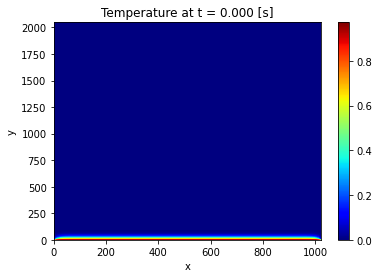

In [13]:
visualize('output_nvc')

#### Exercise 0: `views::cartesian_product` solutions

In [15]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++17 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat solutions/exercise0_cartesian.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
rm: cannot remove 'heat': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 1.01006 GB/s


In [17]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++17 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat solutions/exercise0.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 2.71365 GB/s


#### Exercise 0: pinned device memory with `thrust::device_vector` solution

To benefit from NVLink, a solution using `thrust::device_vector` to allocate device-pinned memory is provided.

This is will no longer be necessary in the next HPC SDK release.

In [27]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -stdpar=gpu  -gpu=cc80 -std=c++20 -fast -DNDEBUG -o heat solutions/exercise0_nomanaged.cpp
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_nvc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 15.9467 GB/s


## Exercise 1: overlapping computation with communication

The goal of this exercise is to overlap communicaiton with computation using `std::thread`, `std::atomic`, and `std::barrier`.

A template for the solution is provided in [exercise1.cpp]. 
[exercise1.cpp]: ./exercise1.cpp

First, notice that the computation involves a data exchange with neighbors and is split into three steps:

* `internal`: processes internal rows that do not depend on data from neighbors
* `prev_boundary`: exchanges data with neighbor at `rank - 1` and processes the rows that depend on the elements received
* `next_boundary`: exchanges data with neighbor at `rank + 1` and processes the rows that depend on the elements received


```c++
double internal(double* u_new, double* u_old, parameters p) {
    grid g { .x_start = 2, .x_end = p.nx, .y_start = 1, .y_end = p.ny - 1 };
    energy += stencil(u_new.get(), u_old.get(), g, p);
}

double prev_boundary(double* u_new, double* u_old, parameters p) {
    // Send window cells, receive halo cells
    if (p.rank > 0) {
      // Send bottom boundary to bottom rank
      MPI_Send(u_old + p.ny, p.ny, MPI_DOUBLE, p.rank - 1, 0, MPI_COMM_WORLD);
      // Receive top boundary from bottom rank
      MPI_Recv(u_old + 0, p.ny,  MPI_DOUBLE, p.rank - 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    }
    grid g { .x_start = p.nx, .x_end = p.nx + 1, .y_start = 1, .y_end = p.ny - 1 };
    return stencil(u_new, u_old, g, p);
}

double next_boundary(double* u_new, double* u_old, parameters p) {
    if (p.rank < p.nranks - 1) {
        // Receive bottom boundary from top rank
        MPI_Recv(u_old + (p.nx + 1) * p.ny, p.ny, MPI_DOUBLE, p.rank + 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        // Send top boundary to top rank, and
        MPI_Send(u_old + p.nx * p.ny, p.ny, MPI_DOUBLE, p.rank + 1, 1, MPI_COMM_WORLD);
    }
    grid g { .x_start = 1, .x_end = 2, .y_start = 1, .y_end = p.ny - 1 };
    return stencil(u_new, u_old, g, p);
}
```

In the previous exercise, these steps are performed sequentially:

```c++
for (long it = 0; it < p.nit(); ++it) {
    double energy = 0.;
    // Exchange and compute domain boundaries:
    energy += prev_boundary(u_new.data(), u_old.data(), p);
    energy += next_boundary(u_new.data(), u_old.data(), p);
    energy += internal(u_new.data(), u_old.data(), p);
    // ...
}
```

In this exercise, we need to modify the application to perform these three steps concurrently and in parallel.

This will require:

* using one `std::thread` per computation in such a way that we do not launch one thread on every iteration
* using `std::atomic<double>` for the `energy`, to enable the separate threads to modify the energy concurrently
* using a `std::barrier` to synchronize the different threads

Furthermore, one of the threads will need to perform the following in a critical section:
  * `MPI_Reduce` of the `energy`: this operation requires for all threads to have updated the `energy` for the current iteration, so it must happen after these updates have completed
  * reset the `energy` to `0.` before the next iteration: all threads must wait for this operation to complete before starting the next iteration
  
The template [exercise1.cpp] provides `TODO`s to guide you through this process: 

```c++
  // TODO: use an atomic variable for the energy
  double energy = 0.;
    
  // TODO: use a barrier for synchronization
  // ...bar = ...

  // TODO: use threads for the different computations
  auto thread_prev = std::thread([/*TODO: complete capture */]() {
      for (long it = 0; it < p.nit(); ++it) {
          // TODO: perform the prev exchange and computation
          // TODO: update the atomic energy
          // TODO: synchronize with the barrier
      }
  });
    
  auto thread_next = /* TODO: similar for prev */;
      
  auto thread_internal = /*
    TODO: same as for next and prev
    TODO: need to perform the reduction in one of the threads (for example this one)
    TODO: need to reset the atomic in one of the threads (for example this one)
  */;

  // TODO: join all threads

```

[exercise1.cpp]: ./exercise1.cpp

### Compilation and run commands


The following commands compile but produce incorrect results.
Your goal is to fix that by following the instructions above.

In [18]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat exercise1.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
Domain 1024x1024 (0.0167772 GB): 2.39675e+08 GB/s


In [19]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -stdpar=gpu  -gpu=cc80,nomanaged -std=c++20 -fast -DNDEBUG -o heat exercise1.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_nvc

rm: cannot remove 'output': No such file or directory
"exercise1.cpp", line 210: warning: variable "energy" was declared but never referenced
    double energy = 0.;
           ^

"exercise1.cpp", line 216: warning: variable "thread_prev" was declared but never referenced
    auto thread_prev = 0 /* std::thread([p, TODO: complete capture]() {
         ^

"exercise1.cpp", line 224: warning: variable "thread_next" was declared but never referenced
    auto thread_next = 0 /* TODO: similar for prev */;
         ^

"exercise1.cpp", line 226: warning: variable "thread_internal" was declared but never referenced
    auto thread_internal = 0 /*
         ^

terminate called after throwing an instance of 'thrust::system::system_error'
  what():  fill_n: failed to synchronize: cudaErrorIllegalAddress: an illegal memory access was encountered
[ipp1-2165:00749] *** Process received signal ***
[ipp1-2165:00749] Signal: Aborted (6)
[ipp1-2165:00749] Signal code:  (-6)
[ipp1-2165:00749] [ 0] /usr/lib

### Solution Exercise 1

The solutions for each example are available in the `solutions/exercise1.cpp` sub-directory.

The following compiles and runs the solutions for Exercise 3 using different compilers and C++ standard versions.

In [21]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -DNDEBUG -isystem/usr/local/range-v3/include  -o heat solutions/exercise1.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_gcc

rm: cannot remove 'output': No such file or directory
rm: cannot remove 'heat': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 2.68618 GB/s


In [22]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -stdpar=gpu  -gpu=cc80 -std=c++20 -fast -DNDEBUG -o heat solutions/exercise1.cpp -ltbb
!OMPI_MCA_coll_hcoll_enable=0 mpirun --oversubscribe --allow-run-as-root -np 2 ./heat 1024 1024 2000
!mv output output_nvc

rm: cannot remove 'output': No such file or directory
E(t=0) = 0.000194931
E(t=0.000190735) = 0.0148522
Domain 1024x1024 (0.0167772 GB): 15.9587 GB/s
